In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from textblob import TextBlob
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [11]:
file_path = r"C:\Users\mudav\Data science\Unified mentor internship\Climate Change Modeling\climate_nasa.csv"
data = pd.read_csv(file_path)
data.head(4)

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...


In [12]:
data = data.dropna(subset=['text']) 
data = data[data['text'].str.strip() != '']  
data.reset_index(drop=True, inplace=True)

In [13]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['sentiment_score'] = data['text'].apply(get_sentiment)
data['sentiment'] = data['sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

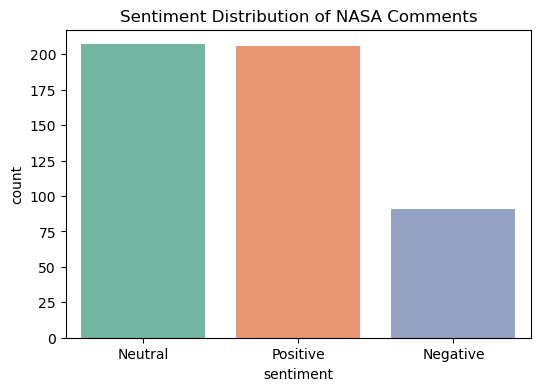

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=data, palette='Set2')
plt.title('Sentiment Distribution of NASA Comments')
plt.show()

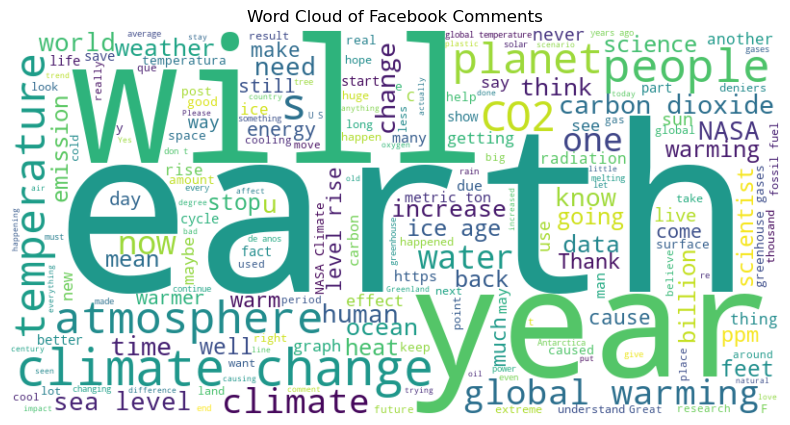

In [15]:
text_combined = " ".join(data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Facebook Comments')
plt.show()

In [16]:
X = data['text']
y = data['likesCount']

In [17]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(X).toarray()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [19]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [20]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 7.39
Mean Squared Error (MSE): 298.37
R² Score: -0.24


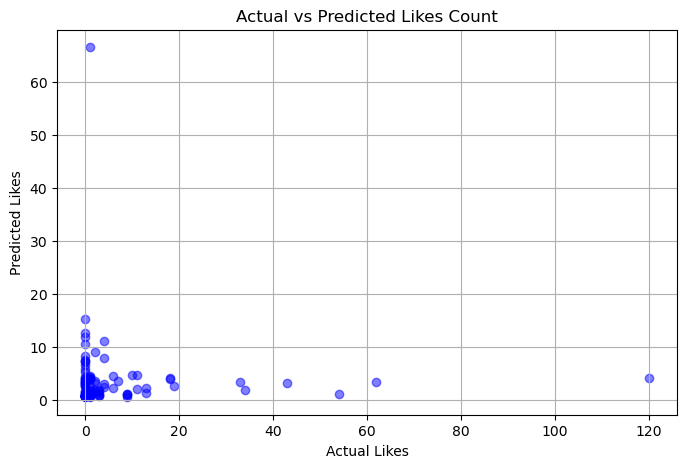

In [21]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.xlabel("Actual Likes")
plt.ylabel("Predicted Likes")
plt.title("Actual vs Predicted Likes Count")
plt.grid(True)
plt.show()

In [1]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.notebook import tqdm
import geopandas as gpd
from shapely.geometry import Point
import folium
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [28]:
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = 100
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)

In [29]:
path=r"C:\Users\mudav\Data science\Unified mentor internship\Climate Change Modeling\climate_nasa.csv"
data=pd.read_csv(path)
data.head(4)

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.00000,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...


In [30]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data = data.dropna(subset=['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['likesCount'] = data['likesCount'].fillna(0)
data['commentsCount'] = data['commentsCount'].fillna(0)
data['engagement'] = data['likesCount'] + data['commentsCount']
data = data.dropna(subset=['text'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 504 entries, 0 to 521
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   date           504 non-null    datetime64[ns, UTC]
 1   likesCount     504 non-null    int64              
 2   profileName    504 non-null    object             
 3   commentsCount  504 non-null    float64            
 4   text           504 non-null    object             
 5   year           504 non-null    int32              
 6   month          504 non-null    int32              
 7   engagement     504 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(2), int32(2), int64(1), object(2)
memory usage: 31.5+ KB


In [31]:
m = folium.Map(location=[28.6, 77.2], zoom_start=4)
tooltip = "Sample Climate Comment"
folium.Marker([28.6, 77.2], popup="NASA Climate Post", tooltip=tooltip).add_to(m)
m


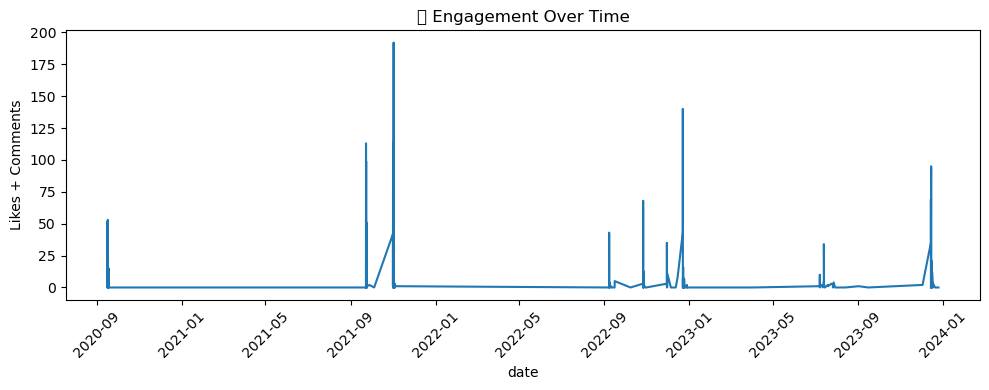

In [32]:
plt.figure(figsize=(10, 4))
sns.lineplot(x='date', y='engagement', data=data)
plt.title("📈 Engagement Over Time")
plt.ylabel("Likes + Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

data['clean_text'] = data['text'].apply(clean_text)
tfidf = TfidfVectorizer(max_features=100)
text_features = tfidf.fit_transform(data['clean_text']).toarray()
text_df = pd.DataFrame(text_features, columns=tfidf.get_feature_names_out())
final_df = pd.concat([data[['year', 'month', 'likesCount', 'commentsCount', 'engagement']], text_df], axis=1)
final_df.head()

,year,month,likesCount,commentsCount,engagement,about,all,also,an,and,...,when,which,will,with,world,would,year,years,you,your
0,2022.00000,9.00000,2.00000,0.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.15348,...,0.00000,0.00000,0.00000,0.23237,0.00000,0.26909,0.00000,0.00000,0.00000,0.00000
1,2022.00000,9.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.83999,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,2022.00000,9.00000,1.00000,3.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,2022.00000,9.00000,4.00000,0.00000,4.00000,0.00000,0.00000,0.00000,0.00000,0.34070,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,2022.00000,9.00000,16.00000,26.00000,42.00000,0.00000,0.00000,0.00000,0.00000,0.16920,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22648,0.00000


In [38]:
X = X.fillna(X.mean())

In [39]:
print("Missing in X:", X.isnull().sum().sum())
print("Missing in y:", y.isnull().sum())

Missing in X: 0
Missing in y: 0


In [40]:
final_df = final_df.dropna(subset=['engagement'])
X = final_df.drop(columns=['engagement'])
y = final_df['engagement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
model = RandomForestRegressor(random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [43]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"Rsquare Score: {r2:.3f}")

RMSE: 2.14
Rsquare Score: 0.974


In [46]:
future_years = pd.DataFrame({
    'year': np.arange(2025, 2031),
    'month': [1, 6, 12, 1, 6, 12],
    'likesCount': [100]*6,
    'commentsCount': [10]*6
})
future_years['engagement'] = future_years['likesCount'] + future_years['commentsCount']
base_tfidf = text_df.mean().to_frame().T.reset_index(drop=True)
base_df = pd.concat([future_years, base_tfidf.loc[base_tfidf.index.repeat(6)].reset_index(drop=True)], axis=1)
future_predictions = model.predict(base_df.drop(columns=['engagement']))
print("Future Engagement Projections:")
print(future_predictions)

Future Engagement Projections:
[105.72 105.72 106.91 105.72 105.72 106.91]


In [5]:
df = pd.read_csv("climate_nasa.csv")
df.dropna(inplace=True)
df['engagement_score'] = df['likesCount'] + df['commentsCount']
features = ['likesCount', 'commentsCount']
X = df[features]
y = df['engagement_score']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
with open("climate_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("features.pkl", "wb") as f:
    pickle.dump(features, f)

print("Model training complete and files saved.")


Model training complete and files saved.


In [ ]:

import streamlit as st
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor


model = pickle.load(open('climate_model.pkl', 'rb'))
features = pickle.load(open('features.pkl', 'rb'))

# App layout
st.set_page_config(page_title="🌍 Climate Change Predictor", layout="centered")
st.title("🌡️ Climate Change Indicator Prediction")
st.markdown("""
This app predicts **climate indicators** such as *Engagement* or *CO2 level* based on environmental features.
Fill the form below to see predictions.
""")


user_input = {}
for col in features:
    user_input[col] = st.number_input(f"Enter value for {col}", step=0.1)


if st.button("Predict"): 
    input_df = pd.DataFrame([user_input])
    prediction = model.predict(input_df)[0]
    st.success(f"📈 Predicted Value: {prediction:.2f}")
    st.balloons()

st.markdown("---")
st.caption("Made with ❤️ for Climate Change Modeling")

In [3]:
import pandas as pd

df = pd.read_csv("climate_nasa.csv")
print(df.columns.tolist())

['date', 'likesCount', 'profileName', 'commentsCount', 'text']
